In [1]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
con = duckdb.connect(database='/Users/raphaellaude/Documents/Projects/dxd/v2/pluto_hist.db')

In [4]:
con.query("install spatial; load spatial;")

In [5]:
sql = " union all ".join(
    f"select column_name, {x} as year from (describe pluto{str(x).zfill(2)}_shp)"
    for x
    in range(2, 24)
)

# cursor = con.execute(f"with columns as ({sql}) select column_name, count(*) from columns group by column_name having count(*) = 22")
cursor = con.execute(sql)

In [6]:
df = cursor.fetch_df()

In [8]:
consistent_cols = df.groupby("column_name").count()
consistent_cols = consistent_cols[consistent_cols.year.eq(22)].copy()
print(len(consistent_cols))

list(consistent_cols.index)

45


['address',
 'areasource',
 'assessland',
 'assesstot',
 'bldgclass',
 'bldgdepth',
 'bldgfront',
 'block',
 'borocode',
 'borough',
 'builtfar',
 'comarea',
 'exempttot',
 'firecomp',
 'geom',
 'histdist',
 'irrlotcode',
 'landmark',
 'landuse',
 'lot',
 'lotarea',
 'lotdepth',
 'lotfront',
 'numbldgs',
 'numfloors',
 'overlay1',
 'overlay2',
 'ownername',
 'ownertype',
 'policeprct',
 'resarea',
 'schooldist',
 'spdist1',
 'spdist2',
 'splitzone',
 'unitsres',
 'unitstotal',
 'xcoord',
 'ycoord',
 'yearalter1',
 'yearalter2',
 'yearbuilt',
 'zipcode',
 'zonedist1',
 'zonedist2']

to include: landuse, zonedist1, assessland, assesstot, numfloors, yearbuilt, unitsres, bldgclass, yearalter1, builtfar

In [9]:
to_include = [
    "landuse", "zonedist1", "assessland", "assesstot",
    "numfloors", "yearbuilt", "unitsres", "bldgclass",
    "yearalter1", "builtfar"
]

In [10]:
consistent_cols.loc[to_include]

,year
column_name,
landuse,22
zonedist1,22
assessland,22
assesstot,22
numfloors,22
yearbuilt,22
unitsres,22
bldgclass,22
yearalter1,22


In [16]:
con.query("""
    select
        distinct case
            when zonedist1 like 'PARK%' then 'PARK'
            when zonedist1 is null then 'NZS'
            else regexp_extract(zonedist1, '^[A-Za-z]+[0-9]*', 0)
        end as zonedist_simple
    from pluto02_shp
""")

┌─────────────────┐
│ zonedist_simple │
│     varchar     │
├─────────────────┤
│ R8              │
│ R10             │
│ R9              │
│ M2              │
│ C4              │
│ R1              │
│ PARK            │
│ M3              │
│ C7              │
│ R3              │
│ ·               │
│ ·               │
│ ·               │
│ C1              │
│ M1              │
│ C5              │
│ BPC             │
│ R5              │
│ R6              │
│ R4              │
│ R2              │
│ C6              │
│ C2              │
├─────────────────┤
│     24 rows     │
│   (20 shown)    │
└─────────────────┘

In [25]:
sql = " union all ".join(
    f"select column_name, column_type from (describe pluto{str(x).zfill(2)}_shp)"
    for x
    in range(2, 24)
)
for col in to_include:
    print(col)
    print(con.query(f"select distinct column_type from ({sql}) where column_name = '{col}'"))

landuse
┌─────────────┐
│ column_type │
│   varchar   │
├─────────────┤
│ VARCHAR     │
└─────────────┘

zonedist1
┌─────────────┐
│ column_type │
│   varchar   │
├─────────────┤
│ VARCHAR     │
└─────────────┘

assessland
┌─────────────┐
│ column_type │
│   varchar   │
├─────────────┤
│ DOUBLE      │
└─────────────┘

assesstot
┌─────────────┐
│ column_type │
│   varchar   │
├─────────────┤
│ DOUBLE      │
└─────────────┘

numfloors
┌─────────────┐
│ column_type │
│   varchar   │
├─────────────┤
│ DOUBLE      │
└─────────────┘

yearbuilt
┌─────────────┐
│ column_type │
│   varchar   │
├─────────────┤
│ INTEGER     │
└─────────────┘

unitsres
┌─────────────┐
│ column_type │
│   varchar   │
├─────────────┤
│ DOUBLE      │
│ INTEGER     │
│ BIGINT      │
└─────────────┘

bldgclass
┌─────────────┐
│ column_type │
│   varchar   │
├─────────────┤
│ VARCHAR     │
└─────────────┘

yearalter1
┌─────────────┐
│ column_type │
│   varchar   │
├─────────────┤
│ INTEGER     │
└─────────────┘

builtf

In [64]:
q = """
    SELECT
        CAST(landuse AS INTEGER) AS landuse,
        case
            when zonedist1 like 'PARK%' then 'PARK'
            when zonedist1 is null then 'NZS'
            else regexp_extract(zonedist1, '^[A-Za-z]+[0-9]*', 0)
        end as zonedist1,
        assessland,
        assesstot,
        numfloors,
        yearbuilt,
        unitsres,
        substring(bldgclass, 1, 1) as bldgclass,
        yearalter1,
        builtfar
    FROM {table} WHERE geom IS NOT NULL
    """
cursor = con.execute(" union all ".join(q.format(table=f"pluto{str(x).zfill(2)}_shp") for x in range(2, 24)))

In [65]:
big_df = cursor.fetch_df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [32]:
big_df.describe()

,landuse,assessland,assesstot,numfloors,yearbuilt,unitsres,yearalter1,builtfar
count,1.874582e+07,1.882401e+07,1.882401e+07,1.882401e+07,1.882401e+07,1.882401e+07,1.882401e+07,1.882401e+07
mean,2.193307e+00,1.028952e+05,3.463605e+05,2.289454e+00,1.834604e+03,4.007535e+00,1.725302e+02,1.106018e+00
std,2.455430e+00,4.757246e+06,9.053465e+06,1.905981e+00,4.400112e+02,3.779287e+01,5.610308e+02,2.460061e+01
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,6.000000e+03,1.927000e+04,2.000000e+00,1.920000e+03,1.000000e+00,0.000000e+00,4.700000e-01
50%,1.000000e+00,1.093600e+04,2.866300e+04,2.000000e+00,1.930000e+03,2.000000e+00,0.000000e+00,7.500000e-01
75%,2.000000e+00,1.771600e+04,5.406000e+04,2.500000e+00,1.955000e+03,2.000000e+00,0.000000e+00,1.250000e+00
max,1.100000e+01,3.211276e+09,7.775388e+09,3.000000e+02,2.040000e+03,4.767400e+04,3.031000e+03,5.208800e+04


In [34]:
big_df.landuse.value_counts()

landuse
1.0     12366644
2.0      2833140
4.0      1107503
11.0      672931
5.0       506706
8.0       261970
3.0       261340
6.0       254582
10.0      252831
7.0       136248
9.0        91923
Name: count, dtype: int64

In [38]:
from empiricaldist import Cdf

In [39]:
def decorate_cdf(title):
    """Labels the axes.
    
    title: string
    """
    plt.xlabel('Quantity')
    plt.ylabel('CDF')
    plt.title(title)

In [44]:
cdf1 = Cdf.from_seq(big_df.assessland)
cdf2 = Cdf.from_seq(big_df.assesstot)

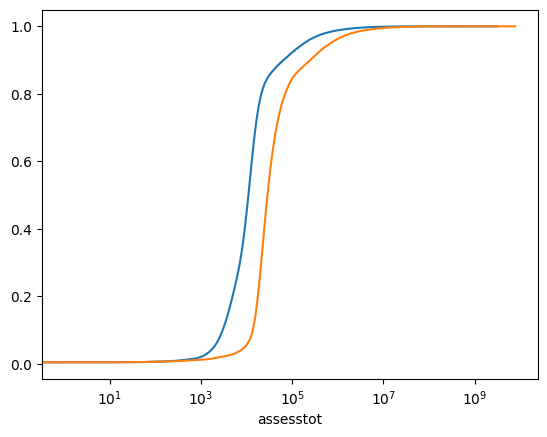

In [45]:
cdf1.plot()
cdf2.plot()
plt.xscale("log")

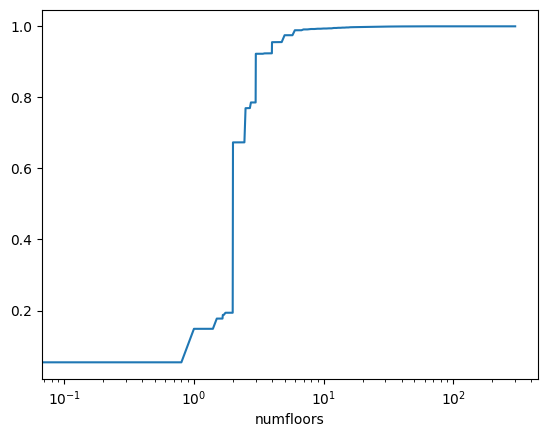

In [47]:
cdf1 = Cdf.from_seq(big_df.numfloors)
cdf1.plot()
plt.xscale("log")

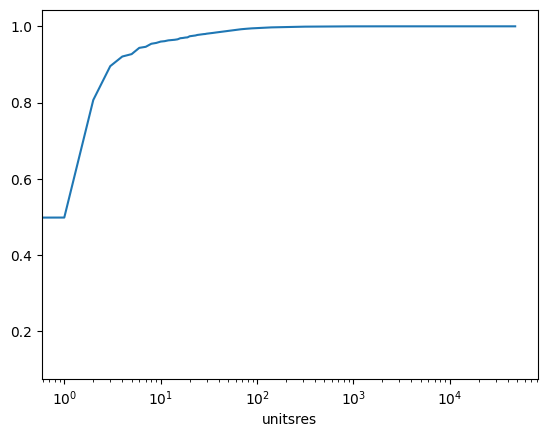

In [58]:
cdf1 = Cdf.from_seq(big_df.unitsres)
cdf1.plot()
plt.xscale("log")

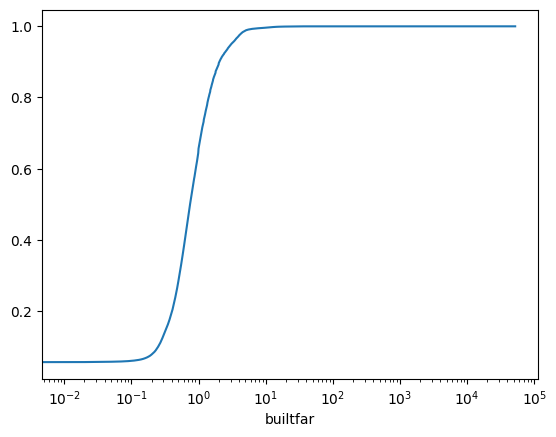

In [57]:
cdf1 = Cdf.from_seq(big_df.builtfar)
cdf1.plot()
plt.xscale("log")

In [66]:
big_df.bldgclass.value_counts()

bldgclass
A    6949975
B    5407437
C    2941763
S     735840
V     673770
K     416385
G     335916
D     300860
O     149229
R     137386
E     132865
M     122495
F      99385
Q      84760
Z      74654
W      61629
U      50563
I      27232
P      23864
L      22246
H      18428
N      13396
Y      11392
T       5470
J       4239
Name: count, dtype: int64

<Axes: ylabel='bldgclass'>

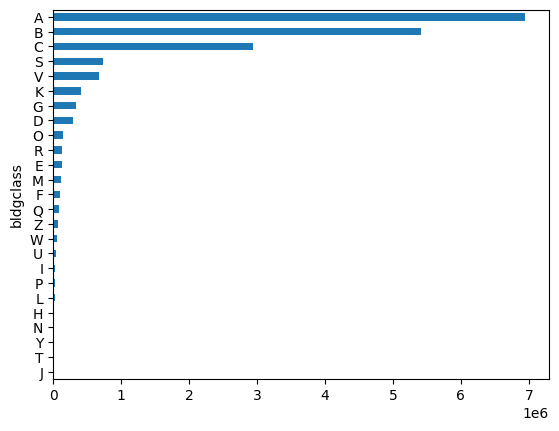

In [68]:
big_df.bldgclass.value_counts()[::-1].plot.barh()